1) Setup & Imports

In [3]:
# 01_EDA.ipynb — Exploratory Data Analysis for FUTURE_ML_01

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)


2) Load Raw Data (robust path + column detection)

In [4]:
# Try typical paths relative to this notebook
candidates = ["../data/raw_sales.csv", "data/raw_sales.csv", "./raw_sales.csv"]
raw_path = next((p for p in candidates if os.path.exists(p)), None)

if raw_path is None:
    raise FileNotFoundError("raw_sales.csv not found. Place it in FUTURE_ML_01/data/")

df_raw = pd.read_csv(raw_path)

print("✅ Loaded:", raw_path)
print("Shape:", df_raw.shape)
df_raw.head()


✅ Loaded: ../data/raw_sales.csv
Shape: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


3) Identify date & target columns (handles Superstore or generic)

In [6]:
# Try to find a date column commonly used in retail datasets
date_col_candidates = ["Order Date", "order_date", "Date", "date"]
date_col = next((c for c in date_col_candidates if c in df_raw.columns), None)

if date_col is None:
    raise ValueError(f"No date column found. Expected one of: {date_col_candidates}")

# Sales / revenue column detection
sales_col_candidates = ["Sales", "sales", "Revenue", "revenue", "Amount", "amount"]
sales_col = next((c for c in sales_col_candidates if c in df_raw.columns), None)

if sales_col is None:
    raise ValueError(f"No sales/revenue column found. Expected one of: {sales_col_candidates}")

print(f"Using date column: {date_col}")
print(f"Using sales column: {sales_col}")


Using date column: Order Date
Using sales column: Sales


4) Basic cleaning (dates, missing, dtypes)

In [7]:
df = df_raw.copy()

# Parse dates (coerce errors → NaT, then drop)
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
before = len(df)
df = df.dropna(subset=[date_col])
after = len(df)

# Clean sales column: coerce to numeric and drop missing
df[sales_col] = pd.to_numeric(df[sales_col], errors="coerce")
df = df.dropna(subset=[sales_col])

print(f"🧹 Dropped {before - after} rows with invalid dates.")
print("Missing values now:\n", df[[date_col, sales_col]].isna().sum())
print("Dtypes:\n", df[[date_col, sales_col]].dtypes)
df.head()


🧹 Dropped 0 rows with invalid dates.
Missing values now:
 Order Date    0
Sales         0
dtype: int64
Dtypes:
 Order Date    datetime64[ns]
Sales                float64
dtype: object


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


5) Aggregate to daily sales

In [8]:
daily = (
    df.groupby(df[date_col].dt.normalize())[sales_col]
      .sum()
      .reset_index()
      .rename(columns={date_col: "Date", sales_col: "Sales"})
      .sort_values("Date")
      .reset_index(drop=True)
)

print("✅ Daily aggregation complete. Shape:", daily.shape)
daily.head()


✅ Daily aggregation complete. Shape: (1237, 2)


,Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,4407.100
4,2014-01-07,87.158


6) Save cleaned daily data → data/cleaned_sales.csv

In [9]:
# Decide output path relative to project root if running from notebooks/
out_candidates = ["../data/cleaned_sales.csv", "data/cleaned_sales.csv"]
cleaned_path = out_candidates[0] if os.path.isdir("../data") else out_candidates[1]

daily.to_csv(cleaned_path, index=False)
print("💾 Saved cleaned daily data →", cleaned_path)


💾 Saved cleaned daily data → ../data/cleaned_sales.csv


7) Quick sanity checks & stats

In [10]:
print("📊 Quick Stats")
print("Date range:", daily["Date"].min().date(), "→", daily["Date"].max().date())
print("Rows (days):", len(daily))
print("Average daily sales:", round(daily["Sales"].mean(), 2))
print("Median  daily sales:", round(daily["Sales"].median(), 2))
print("Max     daily sales:", round(daily["Sales"].max(), 2))


📊 Quick Stats
Date range: 2014-01-03 → 2017-12-30
Rows (days): 1237
Average daily sales: 1857.07
Median  daily sales: 1063.18
Max     daily sales: 28106.72


8) Plot: Daily sales trend

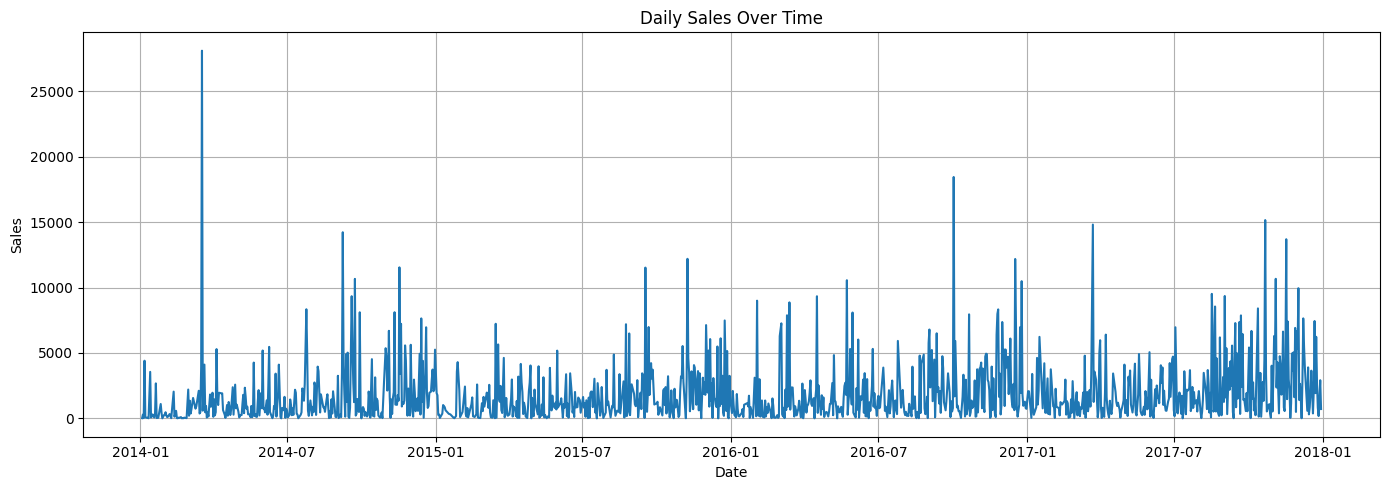

In [11]:
plt.figure(figsize=(14, 5))
plt.plot(daily["Date"], daily["Sales"])
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()


9) Create monthly summary (for seasonality & Power BI)

In [12]:
monthly = (
    daily.assign(Year=daily["Date"].dt.year, Month=daily["Date"].dt.month)
         .groupby(["Year", "Month"], as_index=False)["Sales"].sum()
         .sort_values(["Year", "Month"])
)

# A proper "MonthPeriod" label for plotting
monthly["MonthPeriod"] = pd.to_datetime(monthly["Year"].astype(str) + "-" + monthly["Month"].astype(str) + "-01")

print("✅ Monthly summary ready. Shape:", monthly.shape)
monthly.head()


✅ Monthly summary ready. Shape: (48, 4)


,Year,Month,Sales,MonthPeriod
0,2014,1,14236.895,2014-01-01
1,2014,2,4519.892,2014-02-01
2,2014,3,55691.009,2014-03-01
3,2014,4,28295.345,2014-04-01
4,2014,5,23648.287,2014-05-01


10) Plot: Monthly trend

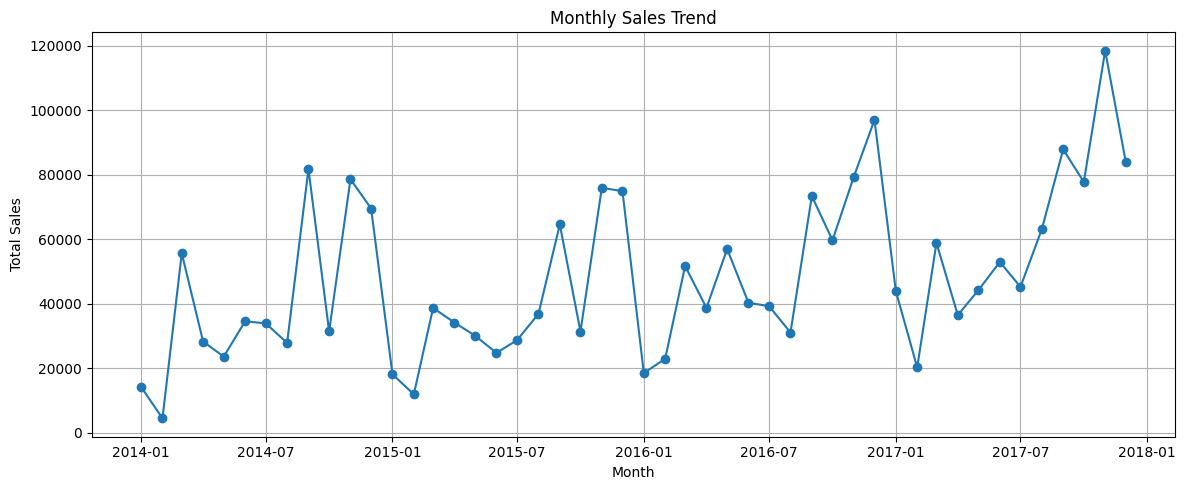

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(monthly["MonthPeriod"], monthly["Sales"], marker="o")
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(True)
plt.tight_layout()
plt.show()


11) Optional: Feature engineering (useful later for models/dashboards)

In [14]:
daily_fe = daily.copy()
daily_fe["Year"] = daily_fe["Date"].dt.year
daily_fe["Month"] = daily_fe["Date"].dt.month
daily_fe["DayOfWeek"] = daily_fe["Date"].dt.dayofweek  # 0=Mon … 6=Sun
daily_fe["IsMonthStart"] = daily_fe["Date"].dt.is_month_start.astype(int)
daily_fe["IsMonthEnd"] = daily_fe["Date"].dt.is_month_end.astype(int)

daily_fe.head()


,Date,Sales,Year,Month,DayOfWeek,IsMonthStart,IsMonthEnd
0,2014-01-03,16.448,2014,1,4,0,0
1,2014-01-04,288.060,2014,1,5,0,0
2,2014-01-05,19.536,2014,1,6,0,0
3,2014-01-06,4407.100,2014,1,0,0,0
4,2014-01-07,87.158,2014,1,1,0,0


12) (Optional) Save monthly summary for Power BI convenience

In [15]:
# Save a ready-to-use monthly file if you want it in Power BI too
monthly_out = "../data/monthly_sales.csv" if os.path.isdir("../data") else "data/monthly_sales.csv"
monthly[["MonthPeriod", "Sales"]].to_csv(monthly_out, index=False)
print("💾 Saved monthly summary →", monthly_out)


💾 Saved monthly summary → ../data/monthly_sales.csv
